# Data Gathering and Preprocessing

## Preliminaries

In [1]:
import os
import pandas as pd
from pytrends.request import TrendReq
import pytrends
from tqdm.notebook import tqdm

In [2]:
path = 'C:\\Users\\Dominique\\Documents\\Work\\ADB\\Nowcasting\\Data'
os.chdir(path)

## Scraping Google Trends data

We define a few helper functions, <code>topic_mapper()</code> and <code>scrape_trends</code> for obtaining Google Trends search data. 

In [3]:
def topic_mapper(terms, types):
    """
    Map overarching topics for given search terms as well as associated suggestions.
    """
    keywords = []
    titles = []
    trend = TrendReq()
    for term in terms:
        l = trend.suggestions(term)
        keywords.append([
            d['mid'] for d in l
            if d['type'] in types
        ])
        titles.append([
            d['title'] for d in l
            if d['type'] in types
        ])
    keywords = [key for sublist in keywords for key in sublist]
    titles = [key for sublist in titles for key in sublist]
    mapping = dict(zip(keywords, titles))
    return mapping

In [4]:
def scrape_trends(countries, mapping, time):
    """
    Scrape search volume intensity for specified countries based on topic mapping. Save results as .csv file. 
    """
    trend = TrendReq()

    for country in tqdm(countries):
        dataset = []
        for x, v in tqdm(mapping.items()):
            #     for x in tqdm(range(0,len(keywords))):
            #         kw = [keywords[x]]
            kw = [str(x)]
            trend.build_payload(kw_list=kw, timeframe=time, geo=country)
            data = trend.interest_over_time()
            if not data.empty:
                data = data.drop(labels=['isPartial'], axis='columns')
                dataset.append(data)
        
        result = pd.concat(dataset, axis=1)
        result.rename(columns=mapping, inplace=True)
        file_name = str(country) + "_search_trends.csv"
        result.to_csv(file_name)

We now define the search terms that we are interested in. The <code>topic_mapper()</code> function automatically gets Google's suggestions, which are categorized into types. For this research, we use the following types:

1. **Topic**: The overarching search term, which has a non-intuitive tag (i.e. <code>/m/0d7pp</code> is the topic for all 'credit card'-related searches).
2. **Transportation mode**: This is relevant for flights and automotives, since we are not interested in, say, scientific research about automotive or flights.
3. **Website**: This is to capture search data for travel-related websites such as Airbnb, booking.com, and others.

In [5]:
terms = [
    'Credit card', 'Banking', 'Online hotel reservations', 'Restaurant',
    'Flights', 'Mobile phone', 'Automotive industry', 'Travel'
]
types = ['Topic', 'Transportation mode', 'Website']

mapping = topic_mapper(terms, types)

Using the <code> scrape_trends()</code> function we defined above, this snippet scrapes and downloads the search trend information for the specified countries. We use only information from 2011 onwards, as the search data are more reliable from that point onwards since Google changed their data collection system. 

In [ ]:
countries = ['AU', 'CN', 'ID', 'IN', 'JP', 'KR', 'MM', 'MY', 'NZ', 'PH', 'SG', 'TH', 'TW', 'VN']
time = '2011-01-01 2020-06-01'

scrape_trends(countries, mapping, time)

## Data Cleaning and Merging

In [10]:
iso = pd.read_excel(path + '\iso_codes.xlsx', header=0)
iso_dict = dict(zip(iso['Alpha-3 code'], iso['Alpha-2 code']))

# renaming to uniform ISO 3-codes
for key, value in iso_dict.items():
    if os.path.isfile(key + ' PMI.xlsx'):
        os.rename(key + ' PMI.xlsx', value + ' PMI.xlsx')

In [29]:
df = pd.read_excel(
    r'C:\Users\Dominique\Documents\Work\ADB\Nowcasting\Data\TW PMI.xlsx',
    skiprows=range(1, 26),
    names=['Date', 'PMI'],
    usecols=[0, 1],
    parse_dates=True)

In [33]:
df.index = pd.DatetimeIndex(df.Date)

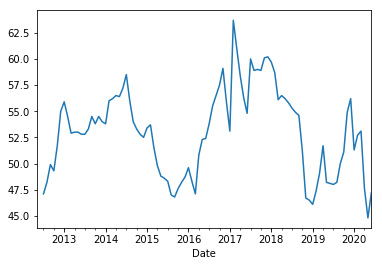

In [34]:
df.PMI.plot()

In [ ]:
result['Card'] = result[[
    'Credit card', 'Cashback reward program', 'Credit card debt'
]].mean(axis=1)

result['Banking'] = result[[
    'Investment banking', 'Mobile banking', 'Private banking'
]].mean(axis=1)

result['Hotels'] = result[[
    'Online hotel reservations', 'The Leading Hotels of the World'
]].mean(axis=1)

result['Automobiles'] = result[['Automotive industry', 'Car']].mean(axis=1)

result['Phones'] = result[['Mobile phone',
                           'Mobile phone accessories']].mean(axis=1)

result['Mobility'] = result[[
    'Google Flights', 'Travel', 'Tourism', 'Travel visa', 'Business travel'
]].mean(axis=1)